In [1]:
NOTEBOOK_NAME = "e000_baseline"

In [2]:
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib

In [3]:
train = pl.read_csv("../sample_data/train.csv")
test = pl.read_csv("../sample_data/test.csv")
sample_submission = pl.read_csv("../sample_data/gender_submission.csv")

# データ型の変更

In [4]:
train.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Ow…","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. …","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Mis…","""female""",26.0,0,0,"""STON/O2. 31012…",7.925,null,"""S"""
4,1,1,"""Futrelle, Mrs.…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,"""Allen, Mr. Wil…","""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


In [5]:
categorical_cols = ["Sex", "Ticket", "Cabin", "Embarked"]

In [6]:
for col in categorical_cols:
    train = train.with_columns(pl.col(col).cast(pl.Categorical).alias(col))
    test = test.with_columns(pl.col(col).cast(pl.Categorical).alias(col))

# Fold

In [7]:
FOLD_NUM = 5

In [8]:
empty = np.zeros(train.height)
fold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=33)

for idx, (_, val_idx) in enumerate(fold.split(train, train.get_column("Survived"))):
    empty[val_idx] = idx

train = train.with_columns(pl.Series(empty).cast(pl.Int64).alias("fold"))

# LightGBM

In [9]:
use_col = []

base_col = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

use_col += base_col
use_col += categorical_cols

len(use_col)

9

In [10]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.05,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
}

In [11]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # polarsをpandasに変換
    train_pd = train.to_pandas()

    # foldごとにtrainとvalidに分ける
    train_fold = train_pd[train_pd["fold"] != fold]
    valid_fold = train_pd[train_pd["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop("Survived", axis=1)
    X_valid = valid_fold.drop("Survived", axis=1)
    y_train = train_fold[["Survived"]]
    y_valid = valid_fold[["Survived"]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100)
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

Start fold 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	training's auc: 0.91321	valid_1's auc: 0.855797
fold 0 Score: 0.8557971014492753
Start fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	training's auc: 0.873152	valid_1's auc: 0.870187
fold 1 Score: 0.870187165775401
Start fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[590]	training's auc: 0.960241	valid_1's auc: 0.895856
fold 2 Score: 0.895855614973262
Start fold 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.878598	valid_1's auc: 0.851136
fold 3 Score: 0.8511363636363636
Start fold 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's auc: 0.941875	valid_1's auc: 0.902074
fold 4 Score: 0.9020741922616673


In [12]:
oof_score = roc_auc_score(y_true=train.get_column("Survived"), y_score=oof)
oof_score

0.8638540035577711

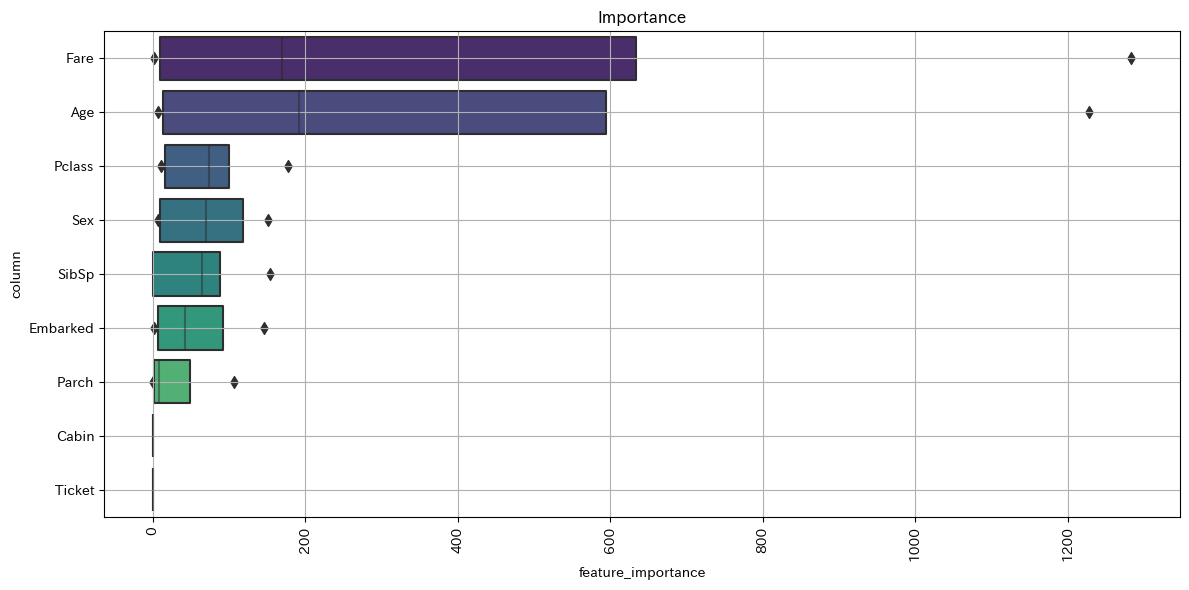

In [13]:
def visualize_importance(models: list, use_col: list) -> None:
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = use_col
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


fig, ax = visualize_importance(models, use_col)

In [14]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test.select(use_col).to_pandas()) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

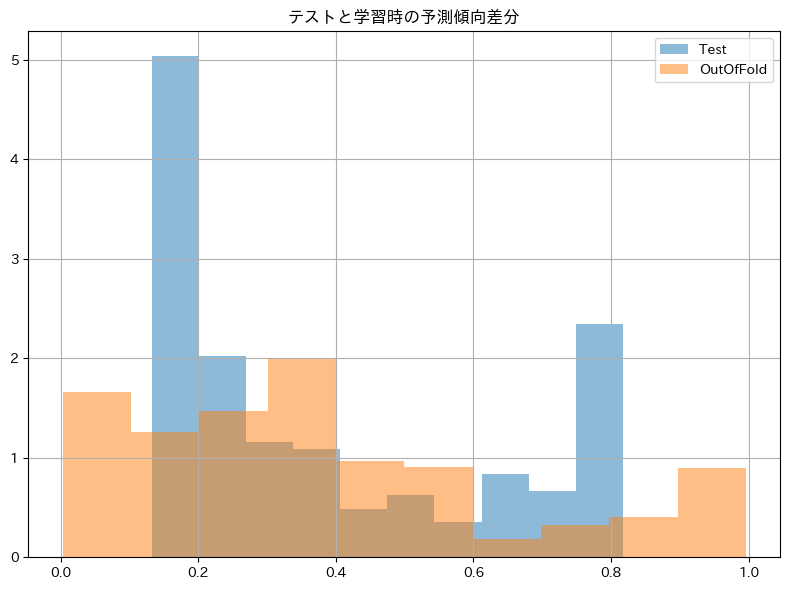

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [16]:
sample_submission.with_columns(pl.Series("Survived", pred > 0.5))
sample_submission

PassengerId,Survived
i64,i64
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [17]:
sample_submission.write_csv(f"../sub/{NOTEBOOK_NAME}_{oof_score}.csv")